# vine copula (vinecop)

- Fitting

> obs -> edge -> tree -> bcp -> (next lv) obs

The function `VineCop.fit` takes multivariate copula observations (of shape $(n,D)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `VineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `VineCop`.

This function can prioritize vertices inside `first_tree_vertex` such that the fitted vine can be used to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `sample_order` attribute inside a `VineCop` object shows sequentially (from right to left, from shallowest to deepest) `D` pseudo-observation (on `D` levels) as source vertices to walk `D` paths until their corresponding `D` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if its opposite upper vertex is not available.

With `first_tree_vertex` given during fitting, the fitted `VineCop` object allows for **conditional simulation**, where `dct_v_s_obs` and `sample_order` can be specified for `.sample()`.


In [1]:
import sys
import platform
import math
import torch
from torch.special import ndtr
import torchvinecopulib as tvc
from torchvinecopulib.util import _EPS

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
print("Python:", sys.version.replace("\n", " "))
print("Platform:", platform.platform())
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

rho = 0.95
V = torch.randn(size=(10000, 2), dtype=torch.float64)
V[:, 1] = rho * V[:, 0] + math.sqrt(1 - rho**2) * V[:, 1]
VV = torch.randn(size=(5000, 2), dtype=torch.float64)
VV[:, 1] = -rho * VV[:, 0] + math.sqrt(1 - rho**2) * VV[:, 1]
V = ndtr(torch.vstack([V, VV])).clamp(_EPS, 1 - _EPS)
obs_mvcp = V
for _ in range(2):
    obs_mvcp = torch.hstack(
        [
            obs_mvcp,
            torch.hstack(
                [
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [0]].reshape(-1, 1),
                    obs_mvcp[torch.randperm(obs_mvcp.shape[0]), [1]].reshape(-1, 1),
                ]
            ),
        ]
    )
obs_mvcp = obs_mvcp[:1000, :7].to(DEVICE)

Python: 3.13.3 (main, Apr  8 2025, 13:54:08) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.4.1-arm64-arm-64bit-Mach-O
PyTorch: 2.7.0
CUDA available: False


In [2]:
num_step_grid = 128
mdl_vcp = tvc.VineCop(
    num_dim=obs_mvcp.shape[1],
    # ! num_step_grid has to be a power of 2 !
    num_step_grid=num_step_grid,
    device=DEVICE,
)
mdl_vcp.fit(obs_mvcp=obs_mvcp, mtd_vine="rvine", first_tree_vertex=(0, 5))
print(mdl_vcp)

VineCop
'num_dim': 6,
 'num_obs': 1_000,
 'mtd_bidep': 'chatterjee_xi',
 'negloglik': -592.4469,
 'num_step_grid': 128,
 'dtype': torch.float64,
 'device': 'cpu',
 'sample_order': (2, 4, 3, 1, 5, 0),
 'matrix':
    tensor([[ 2,  5,  0,  4,  3,  1],
            [-1,  4,  5,  0,  1,  3],
            [-1, -1,  3,  5,  0,  1],
            [-1, -1, -1,  1,  5,  0],
            [-1, -1, -1, -1,  5,  0],
            [-1, -1, -1, -1, -1,  0]], dtype=torch.int32)




(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine level 1'}>,
 <networkx.classes.graph.Graph at 0x157bf5e80>)

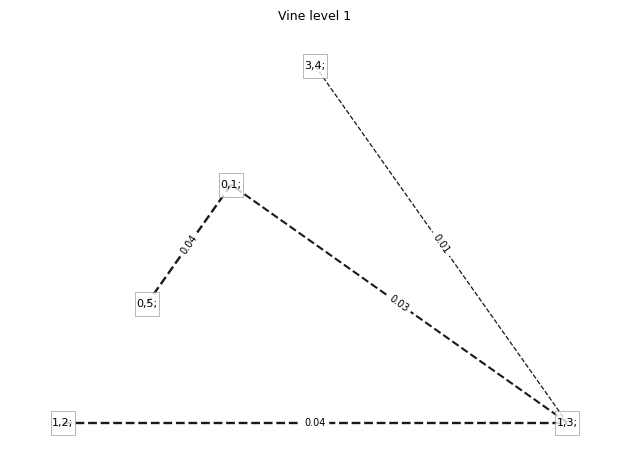

In [3]:
mdl_vcp.draw_lv(lv=1, is_bcp=True)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine comp graph'}>,
 <networkx.classes.digraph.DiGraph at 0x16c591d10>)

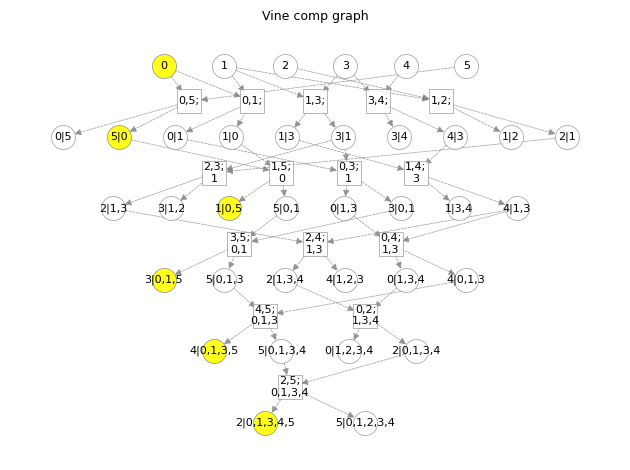

In [4]:
mdl_vcp.draw_dag()

## inside a VineCop obj

- $\frac{D(D-1)}{2}$ bicops (`torch.nn.Module` inside `ModuleDict`)
- parents of bicops
- parents of pseudo-obs
- a `staticmethod` oracle to query the number of h-function calls (and source vertices) given a sampling order on a vine


<Axes: title={'center': 'Estimated bivariate copula density'}, xlabel='$u_{left}$', ylabel='$u_{right}$'>

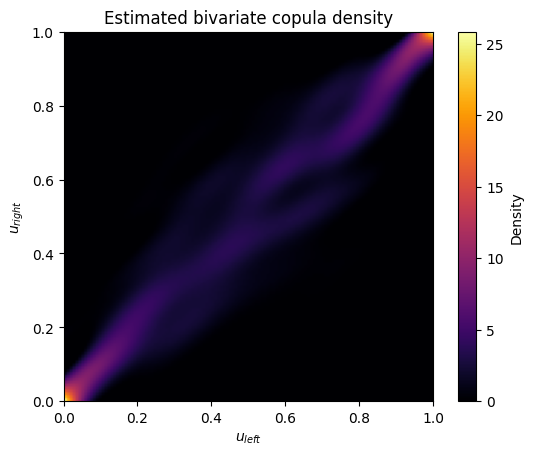

In [5]:
next(iter(mdl_vcp.bicops.values())).imshow()

In [6]:
print(mdl_vcp.bicops, mdl_vcp.struct_bcp, mdl_vcp.struct_obs)
mdl_vcp.ref_count_hfunc(
    num_dim=mdl_vcp.num_dim,
    struct_obs=mdl_vcp.struct_obs,
    sample_order=mdl_vcp.sample_order,
)

ModuleDict(
  (0,1): BiCop()
  (0,2): BiCop()
  (0,3): BiCop()
  (0,4): BiCop()
  (0,5): BiCop()
  (1,2): BiCop()
  (1,3): BiCop()
  (1,4): BiCop()
  (1,5): BiCop()
  (2,3): BiCop()
  (2,4): BiCop()
  (2,5): BiCop()
  (3,4): BiCop()
  (3,5): BiCop()
  (4,5): BiCop()
) {'0,1': {'cond_ed': (0, 1), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '0,2': {'cond_ed': (0, 2), 'cond_ing': (1, 3, 4), 'is_indep': False, 'left': '0,4', 'right': '2,4'}, '0,3': {'cond_ed': (0, 3), 'cond_ing': (1,), 'is_indep': False, 'left': '0,1', 'right': '1,3'}, '0,4': {'cond_ed': (0, 4), 'cond_ing': (1, 3), 'is_indep': False, 'left': '0,3', 'right': '1,4'}, '0,5': {'cond_ed': (0, 5), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,2': {'cond_ed': (1, 2), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,3': {'cond_ed': (1, 3), 'cond_ing': (), 'is_indep': False, 'left': '', 'right': ''}, '1,4': {'cond_ed': (1, 4), 'cond_ing': (3,), 'is_indep': False, 'left': '1,3', 'rig

({(0,): 4,
  (5,): 1,
  (5, 0): 3,
  (1, 0): 3,
  (1, 0, 5): 1,
  (1,): 5,
  (5, 0, 1): 3,
  (3, 0, 1): 3,
  (3, 0, 1, 5): 1,
  (0, 1): 3,
  (3, 1): 4,
  (3,): 3,
  (5, 0, 1, 3): 3,
  (4, 0, 1, 3): 3,
  (4, 0, 1, 3, 5): 1,
  (0, 1, 3): 3,
  (4, 1, 3): 4,
  (1, 3): 2,
  (4, 3): 2,
  (4,): 1,
  (5, 0, 1, 3, 4): 2,
  (2, 0, 1, 3, 4): 2,
  (2, 0, 1, 3, 4, 5): 1,
  (0, 1, 3, 4): 2,
  (2, 1, 3, 4): 2,
  (2, 1, 3): 2,
  (2, 1): 2,
  (2,): 1},
 [(0,), (5, 0), (1, 0, 5), (3, 0, 1, 5), (4, 0, 1, 3, 5), (2, 0, 1, 3, 4, 5)],
 8)

## log_pdf, cdf


In [7]:
mdl_vcp.log_pdf(obs_mvcp=obs_mvcp)

tensor([[-2.2221e-01],
        [-2.1046e+01],
        [ 6.6803e-01],
        [ 1.9357e+00],
        [ 2.1987e+00],
        [ 9.5658e-01],
        [-1.9868e+01],
        [ 3.0007e-01],
        [ 2.3380e-01],
        [ 2.1767e+00],
        [ 8.5837e-01],
        [ 7.5435e-01],
        [ 1.5080e+00],
        [ 2.1668e+00],
        [ 6.3571e-01],
        [ 7.6373e-01],
        [ 7.5135e-01],
        [ 2.6323e-01],
        [ 1.5540e+00],
        [ 1.4257e+00],
        [ 1.6324e+00],
        [ 9.6748e-01],
        [ 1.5172e+00],
        [ 7.1232e-01],
        [ 1.3436e+00],
        [ 5.9237e-01],
        [ 1.5327e+00],
        [ 1.1665e+00],
        [ 1.3555e+00],
        [ 5.1881e-01],
        [ 2.8512e+00],
        [ 5.4815e-01],
        [ 7.3868e-01],
        [ 6.7917e-01],
        [ 3.5700e-01],
        [ 1.9705e+00],
        [ 8.2941e-01],
        [ 1.8587e-02],
        [ 1.7991e+00],
        [ 3.9609e-03],
        [ 9.9547e-01],
        [ 1.5373e+00],
        [ 5.6526e-01],
        [ 1

In [12]:
mdl_vcp.cdf(obs_mvcp=obs_mvcp)

tensor([[1.2140e-02],
        [2.7600e-03],
        [7.0320e-02],
        [3.6260e-02],
        [8.2440e-02],
        [2.3220e-02],
        [1.2800e-03],
        [3.3200e-03],
        [1.0800e-02],
        [1.1460e-02],
        [1.2594e-01],
        [3.7800e-03],
        [7.8400e-03],
        [1.8640e-01],
        [1.4340e-02],
        [3.7400e-01],
        [9.6000e-03],
        [2.0000e-05],
        [5.4000e-04],
        [7.6000e-04],
        [2.3940e-02],
        [1.5000e-03],
        [4.8540e-02],
        [1.3200e-03],
        [2.0420e-02],
        [1.3460e-02],
        [2.4340e-02],
        [8.4000e-03],
        [9.0800e-03],
        [1.2174e-01],
        [2.2000e-04],
        [1.5420e-02],
        [3.5220e-02],
        [4.9600e-03],
        [4.1800e-03],
        [2.6000e-04],
        [2.7860e-02],
        [2.9800e-03],
        [1.7200e-03],
        [1.7400e-03],
        [1.7140e-02],
        [3.6940e-02],
        [1.7540e-02],
        [3.4400e-03],
        [2.7600e-03],
        [7

# (conditional) sampling

- default sampling given $0$ columns of observations
- quantile regression given $D-1$ columns of observations
- conditional simulation otherwise


In [13]:
mdl_vcp.sample()

tensor([[0.0582, 0.0120, 0.4745, 0.0260, 0.4841, 0.0548],
        [0.9552, 0.9006, 0.3315, 0.0945, 0.1556, 0.9361],
        [0.8425, 0.8012, 0.7044, 0.6102, 0.0684, 0.8776],
        ...,
        [0.8312, 1.0000, 0.3209, 0.7255, 0.9528, 0.3167],
        [0.8598, 0.7657, 0.9165, 0.0184, 0.1745, 0.8092],
        [0.8926, 0.8953, 0.9705, 0.0012, 0.9102, 0.7298]], dtype=torch.float64)

In [10]:
mdl_vcp.sample_order

(2, 4, 3, 1, 5, 0)

In [11]:
mdl_vcp.sample(
    num_sample=1000,
    is_sobol=True,
    sample_order=mdl_vcp.sample_order[:-2],
    dct_v_s_obs={
        (mdl_vcp.sample_order[-1],): torch.ones(size=(1000, 1), device=obs_mvcp.device),
        (mdl_vcp.sample_order[-2],): torch.zeros(
            size=(1000, 1), device=obs_mvcp.device
        ),
    },
)

tensor([[1.0000e+00, 1.0000e+00, 4.2579e-01, 7.3533e-02, 8.3333e-01, 1.0000e-07],
        [1.0000e+00, 9.7682e-01, 6.5849e-01, 8.5203e-01, 6.7371e-02, 1.0000e-07],
        [1.0000e+00, 9.6154e-01, 1.3462e-01, 3.4058e-01, 7.0060e-01, 1.0000e-07],
        ...,
        [1.0000e+00, 9.4565e-01, 7.2733e-01, 9.1392e-01, 6.4187e-01, 1.0000e-07],
        [1.0000e+00, 9.6986e-01, 5.0000e-08, 4.2002e-01, 5.0000e-08, 1.0000e-07],
        [1.0000e+00, 9.9481e-01, 9.9781e-01, 6.6892e-01, 7.7143e-01, 1.0000e-07]],
       dtype=torch.float64)